W# Homework 6

## Modeling thermal effects in the battery Single Particle Model

### Suggested due date: before midnight on Wednesday, December 9.

For this assignment we are going to model the evolution of the temperature in our battery single particle model.  Our model will include the following phenomena:

- Ohmic (Joule) heating due to electronic current in cathode and anode solid phases
- Ohmic (Joule) heating due to ionic current in the electrolyte phase in the anode, cathode, and separator pores.
- Heating due to interface reactions in the anode and cathode (chemical and electric energy components)
- Conduction heat transfer between different components (anode, separator, cathode)
- Convection heat transfer at the battery boundaries (anode surface and cathode surface)
- Radiation heat transfer at the battery boundaries (anode surface and cathode surface)


The needed parameters have all been added to the battery `input` file, and calculated as needed in the battery `init` file.  I suggest you read through these files to understand what these parameters represent.

I have also done many of the preliminary calculations needed for your thermal model, in the `function` file.  What is left for you to do is to calculate the volumetric heat generation term, `Q_XX`, where `XX` represents a given phenomena from the bulleted list above.

For the single particle model, we have only three nodes (anode, electrolyte separator, and cathode).  For our thermal model, the, we track a single temperature for each.

You can go ahead and code all the `Q_XX` terms at one time, but we will add these phenomena one at a time, using a series of 'flags' that are set to either 0 or 1.  We will simulate a single charge curve at varying rates, to see the relative impact of each phenomenon, and how it depends on the charging rate of the battery.

Note that there is some internal inconsistency, here: Many of the phenomena above (such as ohmic losses in the electrodes and electrolyte) are not actually incorporated into our battery model (the electrolyte potential, for example, is assumed to be constant at zero).  We also have not incorporated any balance equations for species. For this reason, we will not pay any attention to the cell voltage.

Also, note that _many_ of these properties will vary as a funciton of temperature, in ways that would most certainly impact our temperature evolution.  Our work here will serve as a suitable first approximation, though.

Lastly, FWIW, the included python files demonstrate some new tricks that you might find useful for your project, such as passing 'keywords' when you call a function, which are then passed to the `main` model function.

# Working with this notebook.

1. You should not touch any of the code in the workbook.  All of your coding will be added to the `battery_spm` python files.
2. In this notebook, the only changes you will make are discussing the results.  Each discussion block is highlighted by <font color="red">**red, bold text**</font>.  **Please leave these markers in (do not delete them)**, so that I can easily find your discussion entries.
3. In your discussions, please refer to specific model equations or parameters from the battery spm code, to explain the trends that you see.  
4. If you are making changes to your python code which you feel are not being reflected in these results, you might was to click `Kernel->Restart` (or `Kernel->Restart and Clear Output` or `Kernel->Restart and Run All`) up at the top of this page.  I have added a bunch of code below (all the `importlib.reload` stuff, below), such that you shouldn't need to.  But just in case...
5. Finally, push all of your code (python files and this notebook) to your github repo and make a pull request, to submit.

Good luck!

# Battery cycling function

This function will call our battery model three times, for three different cycling rates (0.1 C, 1.0 C, and 10.0 C).  It will then plot the temperature profiles for the anode, separator, and cathode, as a function of time. Note that a charge at 0.1 C takes 100 times longer than one at 10 C.

In [51]:
# This will make it so that our notebook recognizes and reloads changes we have made in our python files:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
import importlib
def plot_function(ax,sol,ptr,rate):
       
    from matplotlib import pyplot as plt
    ax.plot(sol.t, sol.y[ptr.T_an,:]-273)
    ax.plot(sol.t, sol.y[ptr.T_elyte,:]-273)
    ax.plot(sol.t, sol.y[ptr.T_ca,:]-273)
        
    ax.set_title('C-rate = '+str(rate)+'C',fontsize=14)
    return ax
    

def cycle_function(flags):
    from matplotlib import pyplot as plt

    import battery_spm_init
    importlib.reload(battery_spm_init)
    from battery_spm_init import ptr
    
    import battery_spm_model
    importlib.reload(battery_spm_model)
    from battery_spm_model import cycle
    
    solution_01 = cycle(C_rate = 0.1, thermal_flags = flags)
    
    
    import battery_spm_init
    importlib.reload(battery_spm_init)
    from battery_spm_init import ptr
    
    import battery_spm_model
    importlib.reload(battery_spm_model)
    from battery_spm_model import cycle
    
    solution_1 = cycle(C_rate = 1.1, thermal_flags = flags)


    import battery_spm_init
    importlib.reload(battery_spm_init)
    from battery_spm_init import ptr
    
    import battery_spm_model
    importlib.reload(battery_spm_model)
    from battery_spm_model import cycle
    
    solution_10 = cycle(C_rate = 10, thermal_flags = flags)
    
    fig, axs = plt.subplots(1, 3, constrained_layout=False)
    fig.set_size_inches((12,3))
    axs[0] = plot_function(axs[0],solution_01,ptr,0.1)
    axs[1] = plot_function(axs[1],solution_1,ptr,1.0)
    axs[2] = plot_function(axs[2],solution_10,ptr,10)
    axs[1].legend(['Anode temperature','Separator temperature', 'Cathode temperature'],frameon=False)
    
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    axs[0].set_ylabel('T (C)',fontsize=14)
    
    plt.xlabel('Time (s)', fontsize=16)


# Okay, here is the actual assignment:
## Part I: Baseline: No thermal effects
We set all 'flag' values to zero, which sets all heat sources to zero.  Even if you have not added any code to the model, this part should run fine and give a constant T profile:

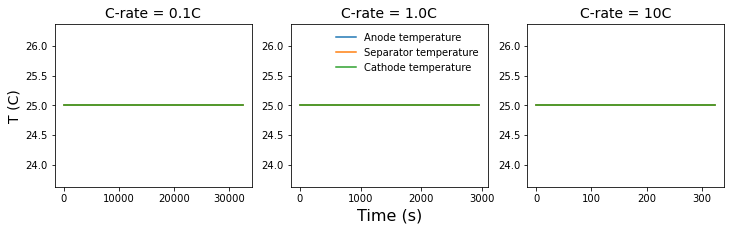

In [53]:
class thermal_flags:
    rxn = 0 # heat due to surface reactions
    ohm_el = 0 # ohmic/Joule heating from electron conduction
    ohm_io = 0 # ohmic/Joule heating from ion conduction
    cond = 0 # Heat transfer via thermal conduciton
    conv = 0 # Heat transfer via external convection
    rad = 0 # Heat tranfer via external radiation
    
cycle_function(thermal_flags)

## Part II: Heat released by reactions

The code already calculates $\dot{s}_{k,{\rm int}}$, the molar production of species due to interfacial reactions, and $e_k = h_k + z_kF\phi_k$, the energy of each species (note that an electron is a specie!).  Fill in the equation `Q_rxn`, the volumetric heating rate (W/m$^3$) due to these reactions.

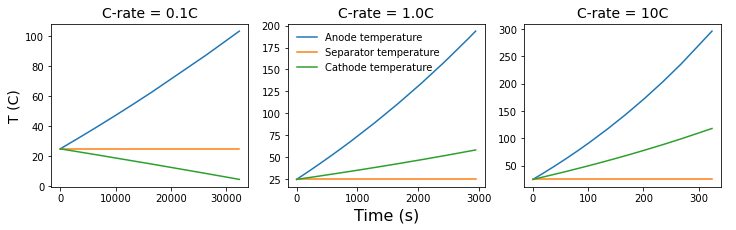

In [54]:
thermal_flags.rxn = 1 # This will stay at 1, from here on out.
cycle_function(thermal_flags)

### Discussion
You should see a dramatic change, relative to Part I.  Discuss these results.  Are they believable?  Would this be a good result for the battery?  Why do we see these trends, and what do you predict will happen as we add in more thermal effects

<font color='red'>[**Discuss right here**]</font> The trends for mode of heating makes sense but for overall battery operation, these temperatures are very high. A rough estimate says that a battery will reach thermal runaway starting around 60 $^\circ$C. For the trends, forming ions in the anode is an exothermic reaction and endothermic in the cathode causing the cathode to decrease in temperature over time at the slower C-rate.  I predict that other modes of heat transfer will disapate the heat generated in the cell to allow the cell to be at a more reasonable temperature.

You should also see the temperature trend for the cathode switch, when going from 0.1C to 1.0C


<font color='red'>[**Why is this?  Refer to the model equations that you added, to explain.**]</font> With the higher C-rates, more energy from the higher potential difference pushes the cathode temperature to increase rather than decrease.

## Part III: Ohmic/Joule Heating

### a. Electron conduction

Add in the equation for the volumetric heating rate due to electron conduction, `Q_ohm_el`.  The code already has calculated `pars.R_el_electrode` for each electrode phase (`pars.R_el_an` and `pars.R_el_ca`), which are the _resistivities_ $\rho_{\rm el}$ (units: $\Omega-m$).

Because we have a single volume for each electrode, we know _a priori_ the electronic current in each electrode (hint: no calculations are needed, for both $i_{\rm elec}$ in the electrodes and $i_{\rm io}$ in the electrolyte phase).

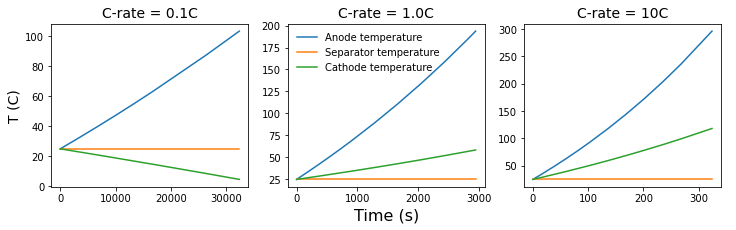

In [55]:
thermal_flags.ohm_el = 1
cycle_function(thermal_flags)

### Discussion:

Do you see any significant changes, relative to Part II?  You should not.  Why?  What does this say about electronic conduction, and which input parameter determined this?

<font color='red'>[**Discuss here**]</font> There is no noticeable change from Part II. This is due to not much power is associated with electronic conduction. Power is small due to the small resistance to electronic conduction (R_el_ed). This means the electrode materials are very conductive.

### b. Ion conduction

Repeat part 1, but for Joule heating due to ion conduction, `Q_ohm_io`.  Note that there is ion conduction in the two electrodes _and_ in the electrolyte separator.

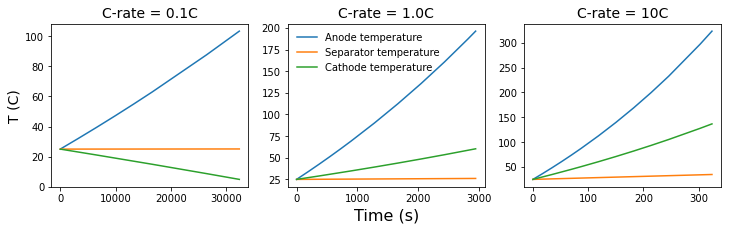

In [56]:
thermal_flags.ohm_io = 1
cycle_function(thermal_flags)

### Discussion:

Do you see any significant changes, relative to Parts II and IIa?  Look closely - there should be some minor changes.  Why?  What does this say about ion conduction, and which input parameter determined this?

Is there a larger impact for some C-rates, compared to others?  Why?

<font color='red'>[**Discuss here**]</font> There is a slight increase in temperature, most noticably in the 1C and 10C cases. This is due to heat generated through conducting an ion through the electrolyte. The resistance to ion conduction comes from the `R_io_ed` terms. Since heat generated through current is typically written as P = I$^2$R, there is an increasing heat generation as the current gets larger with respect to C-rate.

## Part IV: Thermal conduction

Now implement thermal conductivity equations.  This is done in two steps, in the code:

1. Calculate the conduction heat transfer fluxes `Q_cond_an` and `Q_cond_ca`:
- From the anode to the separator: $\dot{Q}^{\prime\prime}_{\rm cond,an} = -\lambda_{avg}\nabla T$ (W/m$^2$)
- From the anode to the separator: $\dot{Q}^{\prime\prime}_{\rm cond,ca} = -\lambda_{avg}\nabla T$ (W/m$^2$)

For both calculations, the volume-weighted average thermal conductivity `lambda` at the relevant electrode/separator interface and the distance between the two volume centers `dyInv` are already calculated for you. 

2. Once the relevant heat fluxes are calculated, calculate the relevant volumetric heat generation terms due to conduction `Q_cond` for the anode, separator, and cathode.

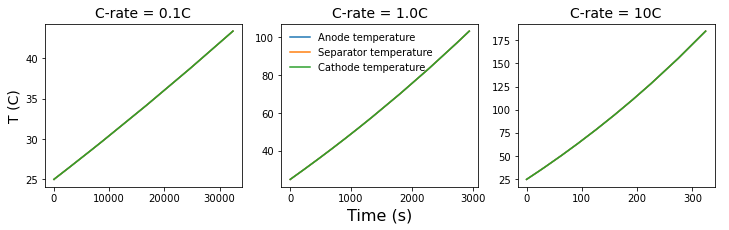

In [57]:
thermal_flags.cond = 1
cycle_function(thermal_flags)

### Discussion:

There should once again be a significant change, relative to Part III. You should see that the anode, separator, and cathode temperatures have all collapsed onto one another. Why is that?  What properties in our inputs lead to this behavior?

What happens to the overall magnitude of the temperatures, relative to part III?  Does this make sense, based on our cell geometry?  What does it say about the "thermal mass" of each component?

Do you think these results are accurate?  Why or why not?  Would _this_ be a good temperature profile, for a battery (i.e. would we want our battery to experience these temperatures?)

<font color='red'>[**Discuss here**]</font> In heat transfer, heat moves through a medium from a high temperature to a lower temperature. The resistance to that heat transfer is the heat conductivity of the medium or how well the material can conduct heat. Here, $\lambda_{cond}$ is the heat conductivity term for each component. Higher $\lambda_{cond}$ results in less resistance to heat transfer. 

The temperature of the cell comes to sort of a weighted average of all of the nodes. The temperature is a little higher than the actual average. This is due to the anode being hotter and larger or equal to the size of the other volumes. If the seperator or cathode were larger, the would have a large heat capacity or 'thermal mass' causing more energy to flow into those nodes while keeping the temperature lower. 

The shape of the temperature profiles are not uncommom. In my research, experimental data on a spiral battery shows a linear increase from 35 to 50 $^\circ$C for an 8C discharge. With that being said, these temperatures are still too hot.

## Part V: Radiation heat transfer

Now implement radiation heat transfer at the battery surface (anode and cathode bondaries).
\begin{equation}
    \dot{Q}^{\prime\prime}_{\rm rad} = \sigma\epsilon\left(T^4_{\rm amb} - T^4_{\rm surf}\right)\frac{A}{V}
\end{equation}
The model code has already defined `sigma`, the Stefan-Boltzmann constant, plus `pars.emmissivity`, the surface emmissivity ($\epsilon$), the ambient temperature `pars.T_amb`, and `pars.A_ext`, the surface area per unit volume for both electrodes, (i.e. $\frac{A}{V}$ in the equation above. Tthe same value is used for both electrodes).

Calculate `Q_rad`, the total heat transferred to each component per unit volume.


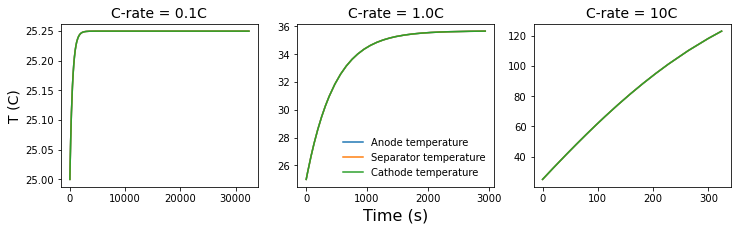

In [58]:
thermal_flags.rad = 1
cycle_function(thermal_flags)

### Discussion 
What do you notice?  Is this believable?  Why do some C-rates reach a steady-state value, and some do not?

For those that do reach a steady-state temperature, what determines the steady state value?  What processes are being balanced, at steady state?

<font color='red'>[**Discuss the results here**]</font> With the addition of radiative heat transfer, the temperatures are a lot lower than in Part IV. Radiation is allowing an interaction with the battery and its surroundings, allowing heat to be removed from the battery instead of all of it just being contained within the cell. For the cells that reach a steady state, the rate of energy removal from the cell is the same as the rate being generated within the cell. For the 10C rate, the balance of energy removal and energy generation has not yet been reached. Lowering the ambient temperature for the 10C case would create a larger temperature difference driving a higher rate of energy extraction. The heat generation processes are those in Parts II and III. Conduction doesn't generate any heat but allows heat to move within the cell nodes. Radiative (and in the next section convection) are the processes that remove heat.

## Part VI: Convection heat transfer.

Now we'll turn radiation back off, and instead model convective heat transfer at the boundary.  Similar to above, calculate a `Q_rad` value: 
\begin{equation}
    \dot{Q}^{\prime\prime}_{\rm conv} = h_{\rm conv}\left(T_{\rm amb} - T_{\rm surf}\right)\frac{A}{V}
\end{equation}
where `pars.h_conv` is already defined for you (same value for anode and cathode).

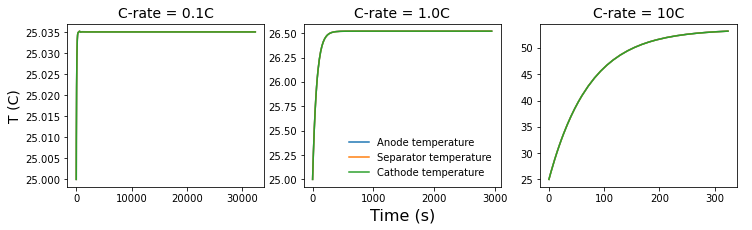

In [59]:
thermal_flags.rad = 0
thermal_flags.conv = 1
cycle_function(thermal_flags)

### Discussion 

What do you notice?  What does this say about the relative influence of convection vs. radiation heat transfer, for the given input parameters?

<font color='red'>[**Discuss the results here**]</font> For the given input parameters, convective heat transfer extracts more energy than radiative. This allows all cases to come to a steady state (or close to) value. With the same parameters, there would be a point where radiative heat transfer would dominate convective heat transfer. This is due to temperature being raised to the 4th power. One thing that is similiar between the two is the 0.1C rate almost instantaneously comes to a steady-state value. This leads to the thinking that at that low of a C-rate, the cell is not generating a lot of heat.

## Part VII: Putting it all together

Okay, finally, incorporate all thermal effects:

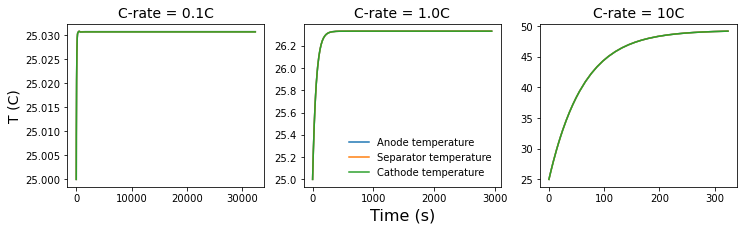

In [60]:
thermal_flags.rad = 1
cycle_function(thermal_flags)

### Discussion

Now that we have all thermal effects incorporated, answer a few final questions:

1.  Would _this_ be a good temperature for our battery?

<font color='red'>[**Discuss here**]</font> For all C-rates, this would be a very acceptable temperature profile. 

2.  If we incorporated temperature dependent parameters, how do you think our results would change?  Be specific: which parameters would change, and how would this impact our various thermal terms (i.e. conduction, ohmic, etc...)

Note: For some parameters (ahem, _species thermo_), we don't really have enough info to say exactly how the results would change.  Saying "I don't know, but it would depend on X, Y, Z" is perfectly fine.

<font color='red'>[**Discuss here**]</font> In this study, thermal conductivity ($\lambda_{cond}$) and electrical conductivity ($\sigma_{ed}$) would have an impact on the results. Typically, as temperature rises, both of these conductivities would increase. This would results in a decreased resistance to electrical and thermal transfer and therefore, lower cell temperature. If $i_\circ$ in the Butler-Volmer equation had a temperature dependence, the energy barrier for a reaction would decrease, increasing both the forward and reverse current rates. This would also results in an overall lower cell temperature.

3. Discuss the influence of C-rate on our battery's thermal response.  Is the relationship between C-rate and max temperature linear? (hint: it is not) Why do you think this is?  What about the dynamic response?  With increasing C-rate, we see that the battery takes _a greater fraction of the total charge time_ to reach steady state. Why is that?  Is the dynamic response actually slower at higher C-rate, or is there something else going on?

<font color='red'>[**Discuss here**]</font> The relationship between max temperature and C-rate is not linear due to the I$^2$R heat generation terms. With respect to the dynamic response, this model does not change it's material properties or geometry or have any temperature dependant parameters. If that's the case, this model could be considered a lumped thermal model where the dynamic response doesn't change. What does change is the rate of heat generation within the cell as the C-rate increases. It's this effect that causes the dynamic response of the cell to change. The heat generation within the battery is again related to heat released by reactions and terms that model I$^2$R heat generation. 

# Thanks for a really great semester.  You've all worked incredibly hard, under difficult circumstances, and I've been impressed by all that you've learned, and sincerely enjoyed getting to spend Tuesdays and Thursdays with you!

## Please feel free to stay in touch, after the semester is over.  I'll leave the Slack workspace open, so long as people are using it.

## If there is any way I can be of use/assistance, either during your time at Mines or beyond, don't hesitate to reach out!  Slack is best, so long as the workspace remains open.